In [2]:
import rosbag
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
bag_file = "1_person_gaussian_data/data/1735836658.866576-interactive-SmallWarehouse-Random-1.bag"
bag = rosbag.Bag(bag_file)

# List available topics
print("Available topics:")
print(bag.get_type_and_topic_info().topics)

Available topics:
{'/center_depth/camera_info': TopicTuple(msg_type='sensor_msgs/CameraInfo', message_count=231, connections=1, frequency=7.692244490742099), '/mobile_base_controller/cmd_vel': TopicTuple(msg_type='geometry_msgs/Twist', message_count=308, connections=1, frequency=7.692357351409246), '/move_base_simple/goal': TopicTuple(msg_type='geometry_msgs/PoseStamped', message_count=4, connections=1, frequency=0.09980039464221606), '/robot_firstperson_rgb/camera_info': TopicTuple(msg_type='sensor_msgs/CameraInfo', message_count=231, connections=1, frequency=7.692244490742099), '/robot_overhead_rgb/camera_info': TopicTuple(msg_type='sensor_msgs/CameraInfo', message_count=231, connections=1, frequency=7.692244490742099), '/robot_thirdperson_rgb/camera_info': TopicTuple(msg_type='sensor_msgs/CameraInfo', message_count=232, connections=1, frequency=7.692244490742099), '/scan': TopicTuple(msg_type='sensor_msgs/LaserScan', message_count=231, connections=1, frequency=7.692244490742099), '/

In [4]:
topic = '/social_sim/agent_positions'

# Store extracted data
pedestrian_timestamps = []
pedestrian_x = []
pedestrian_y = []

for topic, msg, t in bag.read_messages(topics=[topic]):
    for pose in msg.poses:  # Iterate over the poses array
        pedestrian_x.append(pose.position.x)
        pedestrian_y.append(pose.position.y)
        pedestrian_timestamps.append(t.to_sec())

pedestrian_normalized_time = (np.array(pedestrian_timestamps) - min(pedestrian_timestamps)) / (max(pedestrian_timestamps) - min(pedestrian_timestamps) + 1e-6)

# Define the interval for undersampling (e.g., take every 5th point)
sampling_interval = 10

# Undersample by selecting every `sampling_interval`-th data point
undersampled_pedestrian_x = pedestrian_x[::sampling_interval]
undersampled_pedestrian_y = pedestrian_y[::sampling_interval]
undersampled_pedestrian_normalized_time = pedestrian_normalized_time[::sampling_interval]



In [5]:
topic = '/tf'

robot_timestamps = []
robot_x = []
robot_y = []

for topic, msg, t in bag.read_messages(topics=[topic]):
    for transform in msg.transforms:
        if transform.header.frame_id == "map" and transform.child_frame_id == "base_link":
            robot_x.append(transform.transform.translation.x)
            robot_y.append(transform.transform.translation.y)
            robot_timestamps.append(t.to_sec())

robot_normalized_time = (np.array(robot_timestamps) - min(robot_timestamps)) / (max(robot_timestamps) - min(robot_timestamps))

undersampled_robot_x = robot_x[::sampling_interval]
undersampled_robot_y = robot_y[::sampling_interval]
undersampled_robot_normalized_time = robot_normalized_time[::sampling_interval]





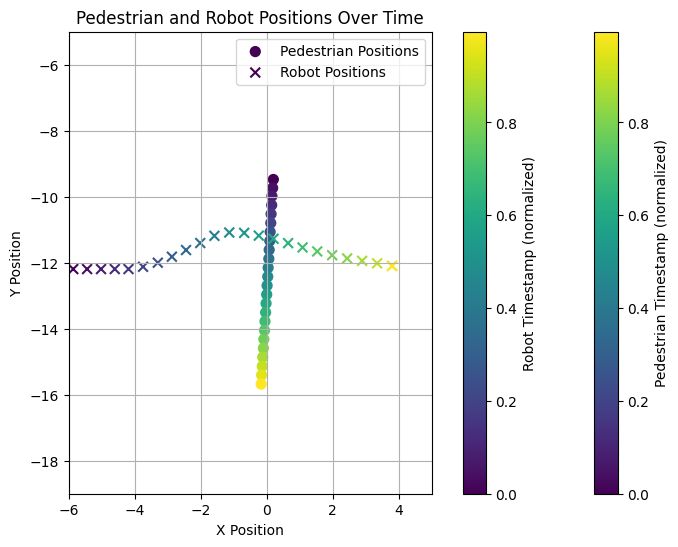

In [6]:
combined_x = pedestrian_x + robot_x
combined_y = pedestrian_y + robot_y
combined_time = pedestrian_normalized_time + robot_normalized_time

# Plot the data
plt.figure(figsize=(10, 6))

# Plot pedestrian positions
scatter_pedestrian = plt.scatter(
    undersampled_pedestrian_x, 
    undersampled_pedestrian_y, 
    c=undersampled_pedestrian_normalized_time, 
    cmap='viridis', 
    s=50, 
    marker='o',
    label='Pedestrian Positions'
)

# Plot robot positions
scatter_robot = plt.scatter(
    undersampled_robot_x, 
    undersampled_robot_y, 
    c=undersampled_robot_normalized_time, 
    cmap='viridis', 
    s=50, 
    marker='x', 
    label='Robot Positions'
)

# Add colorbars for both datasets
plt.colorbar(scatter_pedestrian, label="Pedestrian Timestamp (normalized)")
plt.colorbar(scatter_robot, label="Robot Timestamp (normalized)")

# Labels and title
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Pedestrian and Robot Positions Over Time')

# Ensure equal scaling and add grid
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-6, 5)  # Adjust as per your data range
plt.ylim(-19, -5)  # Adjust as per your data range
plt.grid(True)

# Show legend
plt.legend()

# Display plot
plt.show()